transfer learning between a 2D gamma and a 2D gaussian. I used a quantum circuit with 2 qubits and 1 layer and there is not entanglement gates between them, the total number of trainable paramaters is 12. 

In [1]:
from scipy.special import kl_div,rel_entr
import numpy as np
from matplotlib import pyplot as plt
import quantum_classical_2Dgamma as qc

import tensorflow as tf
from matplotlib import pyplot
from qibo import gates, hamiltonians, models, set_backend, set_threads
from matplotlib import cm
from matplotlib import pyplot as plt, colors
from matplotlib.offsetbox import AnchoredText
import pandas as pd

[Qibo 0.1.7|INFO|2022-04-19 20:09:28]: Using tensorflow backend on /device:CPU:0
[Qibo 0.1.7|WARNING|2022-04-19 20:09:28]: qibotf library was not found. `tf.einsum` will be used to apply gates. In order to install Qibo's high performance custom operators for TensorFlow please use `pip install qibotf`. Alternatively, consider installing the qibojit backend.
[Qibo 0.1.7|INFO|2022-04-19 20:09:29]: Using tensorflow backend on /device:CPU:0


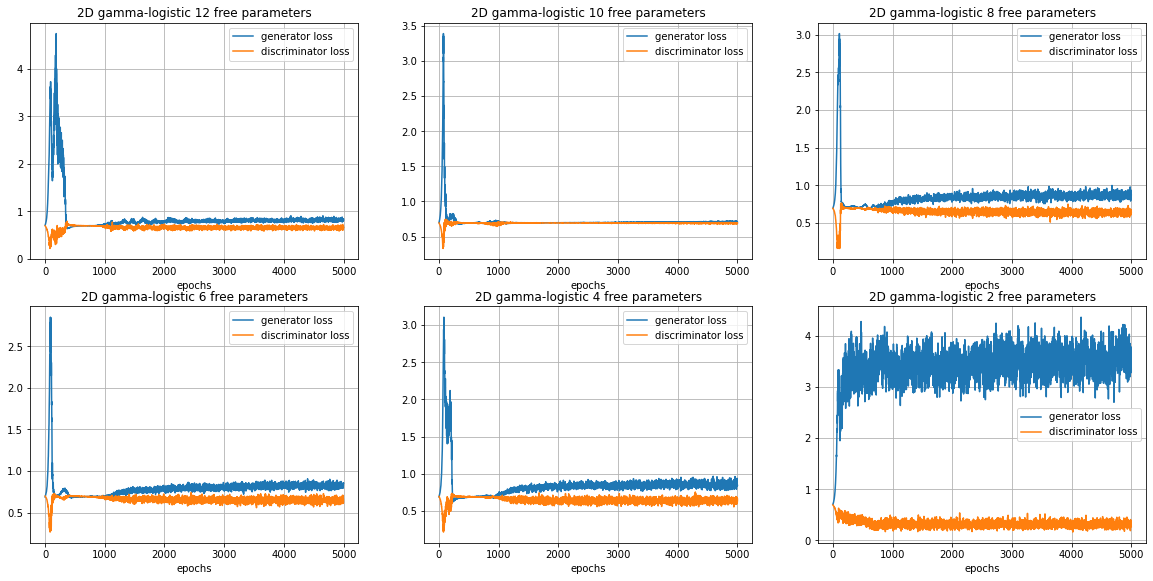

In [2]:
n_layers=128
fixed_params=range(0,12,2)
pyplot.figure(figsize=(20,20))
rows=4
cols=3


for i, val in enumerate(fixed_params):
    pyplot.subplot(rows,cols,i+1)
    d_loss = np.loadtxt(f"data/dloss_2Dgaussian_2_3_1_10000_{n_layers}_0.1_{val}", delimiter=' ')
    g_loss= np.loadtxt(f"data/gloss_2Dgaussian_2_3_1_10000_{n_layers}_0.1_{val}", delimiter=' ')
    #d_loss=d_loss[:10000]
    #g_loss=g_loss[:10000]
    #pyplot.figure(figsize=(20, 7), dpi=80)
    pyplot.plot(np.linspace(0, len(g_loss), len(g_loss)), g_loss, label='generator loss')
    pyplot.plot(np.linspace(0, len(g_loss), len(g_loss)), d_loss, label='discriminator loss')
    pyplot.title(f'2D gamma-logistic {12-val} free parameters')
    pyplot.xlabel('epochs')
    pyplot.legend()
    pyplot.grid()

pyplot.show()

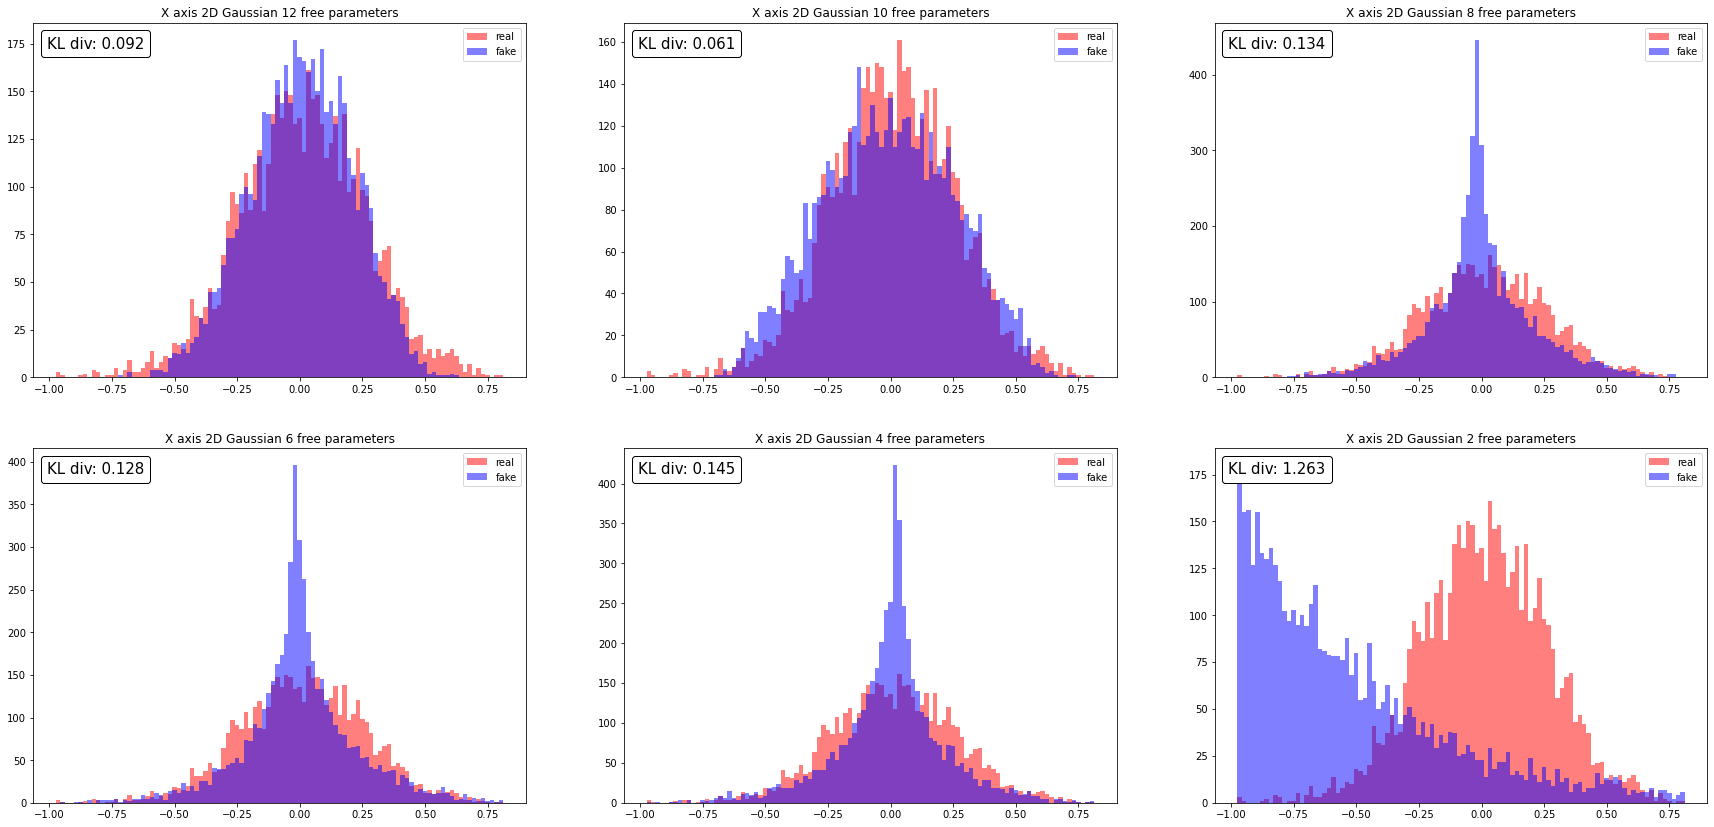

In [3]:
def hamiltonian1():
        id = [[1, 0], [0, 1]]
        m0 = hamiltonians.Z(1).matrix
        m0 = np.kron(m0,id)
        ham = hamiltonians.Hamiltonian(2, m0)
        return ham
    
def hamiltonian2():
        id = [[1, 0], [0, 1]]
        m0 = hamiltonians.Z(1).matrix
        m0 = np.kron(id,m0)
        ham = hamiltonians.Hamiltonian(2, m0)
        return ham
    
def kl_divergence(bins_real, bins_fake,epsilon):
    
    epsilon=0.1
    prob_real=[]
    prob_fake=[]
    for i in range (len(bins_real)):
        prob_real.append(bins_real[i]+epsilon)
        prob_fake.append(epsilon+bins_fake[i])

    #print(prob_fake,prob_real)  

    prob_real=prob_real/sum(prob_real) # probability for each bin (Normalization)
    prob_fake=prob_fake/sum(prob_fake)

   
    return sum(prob_real[i] * np.log(prob_real[i]/prob_fake[i]) for i in range(len(prob_real)))# Convergence problem if a[i] or b[i] equals zero. 
                                                            #I add a little quantity to each bin to avoid problems
   

nqubits = 2
latent_dim=3
samples=5000
layers=1
nbins=100
training_samples=5000



# create hamiltonians
    
hamiltonian1 = hamiltonian1()
hamiltonian2 = hamiltonian2()
   
# create quantum generator
circuit = models.Circuit(nqubits)
for l in range(layers):
    for q in range(nqubits):
        circuit.add(gates.RY(q, 0))
        circuit.add(gates.RZ(q, 0))
        
    #circuit.add(gates.CRY(0, 1, 0))
            
for q in range(nqubits):
    circuit.add(gates.RY(q, 0))

fig = plt.figure(figsize=(30,30))

distributionsX=[]
distributionsY=[]

s = qc.generate_training_real_samples(training_samples)
real_distr,_ = qc.generate_real_samples(samples, s, training_samples)
real_distr=tf.transpose(real_distr)

distributionsX.append(real_distr[0])
distributionsY.append(real_distr[1])

for i, val in enumerate(fixed_params):
    
    pyplot.subplot(rows,cols,i+1)
    
    params = np.loadtxt(f"data/PARAMS_2Dgaussian_2_3_1_10000_{n_layers}_0.1_{val}", delimiter=' ', unpack='true')

    params = tf.Variable(params)
    
    fake_distr, _ = qc.generate_fake_samples(params, latent_dim, samples, circuit, nqubits, layers, hamiltonian1,hamiltonian2,val)
    fake_distr=tf.transpose(fake_distr)
    
    distributionsX.append(fake_distr[0])
    distributionsY.append(fake_distr[1])

    bins_real=pyplot.hist(real_distr[0].numpy(), color='red', bins=nbins,label='real', alpha=0.5)
    bins_fake=pyplot.hist(fake_distr.numpy()[0], bins=bins_real[1],color='blue', label='fake', alpha=0.5)

    pyplot.legend()
    pyplot.title(f"X axis 2D Gaussian {12-val} free parameters")
    
    ax=pyplot.gca()
    at = AnchoredText(
        f"KL div: {'%.3f' %kl_divergence(bins_real[0],bins_fake[0],epsilon=0.1)}", prop=dict(size=15), frameon=True, loc='upper left')
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    ax.add_artist(at)

pyplot.show()

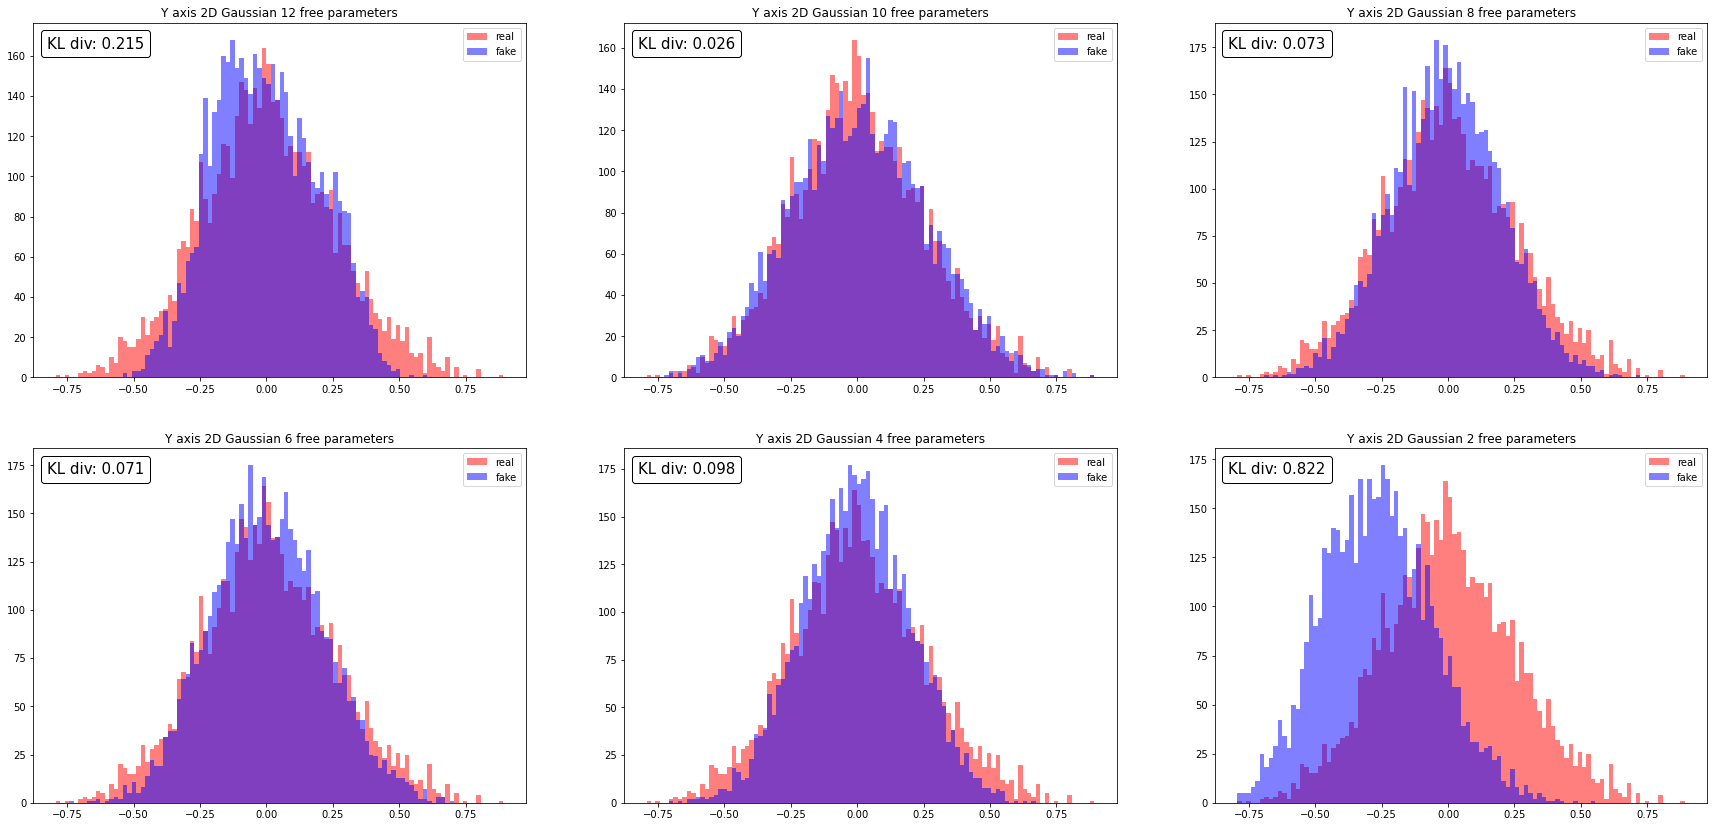

In [4]:
fig = plt.figure(figsize=(30,30))

for i, val in enumerate(fixed_params):
    
    pyplot.subplot(rows,cols,i+1)
    
    bins_real=pyplot.hist(real_distr[1].numpy(), color='red', bins=nbins,label='real', alpha=0.5)
    bins_fake=pyplot.hist(distributionsY[i+1].numpy(), bins=bins_real[1],color='blue', label='fake', alpha=0.5)

    pyplot.legend()
    pyplot.title(f"Y axis 2D Gaussian {12-val} free parameters")
    
    ax=pyplot.gca()
    at = AnchoredText(
        f"KL div: {'%.3f' %kl_divergence(bins_real[0],bins_fake[0],epsilon=0.1)}", prop=dict(size=15), frameon=True, loc='upper left')
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    ax.add_artist(at)


pyplot.show()

In [5]:
print(circuit.draw())

q0: ─RY─RZ─RY─
q1: ─RY─RZ─RY─


In the X axis 2D gaussian we can notice a bad performance when the model is trained with a high number of free parameters, this is due to the way the parameters are fixed in the quantum circuit. At first the RY and RZ of the first qubit, then the RY and RZ of the second one and at the end the RY of q0.

Now we compare the fake data of the transfer learning and the fake data with the normal qGAN.

In [6]:
x,y = np.loadtxt("data/fake_data.dat",delimiter=' ', usecols=(0, 1), unpack=True)

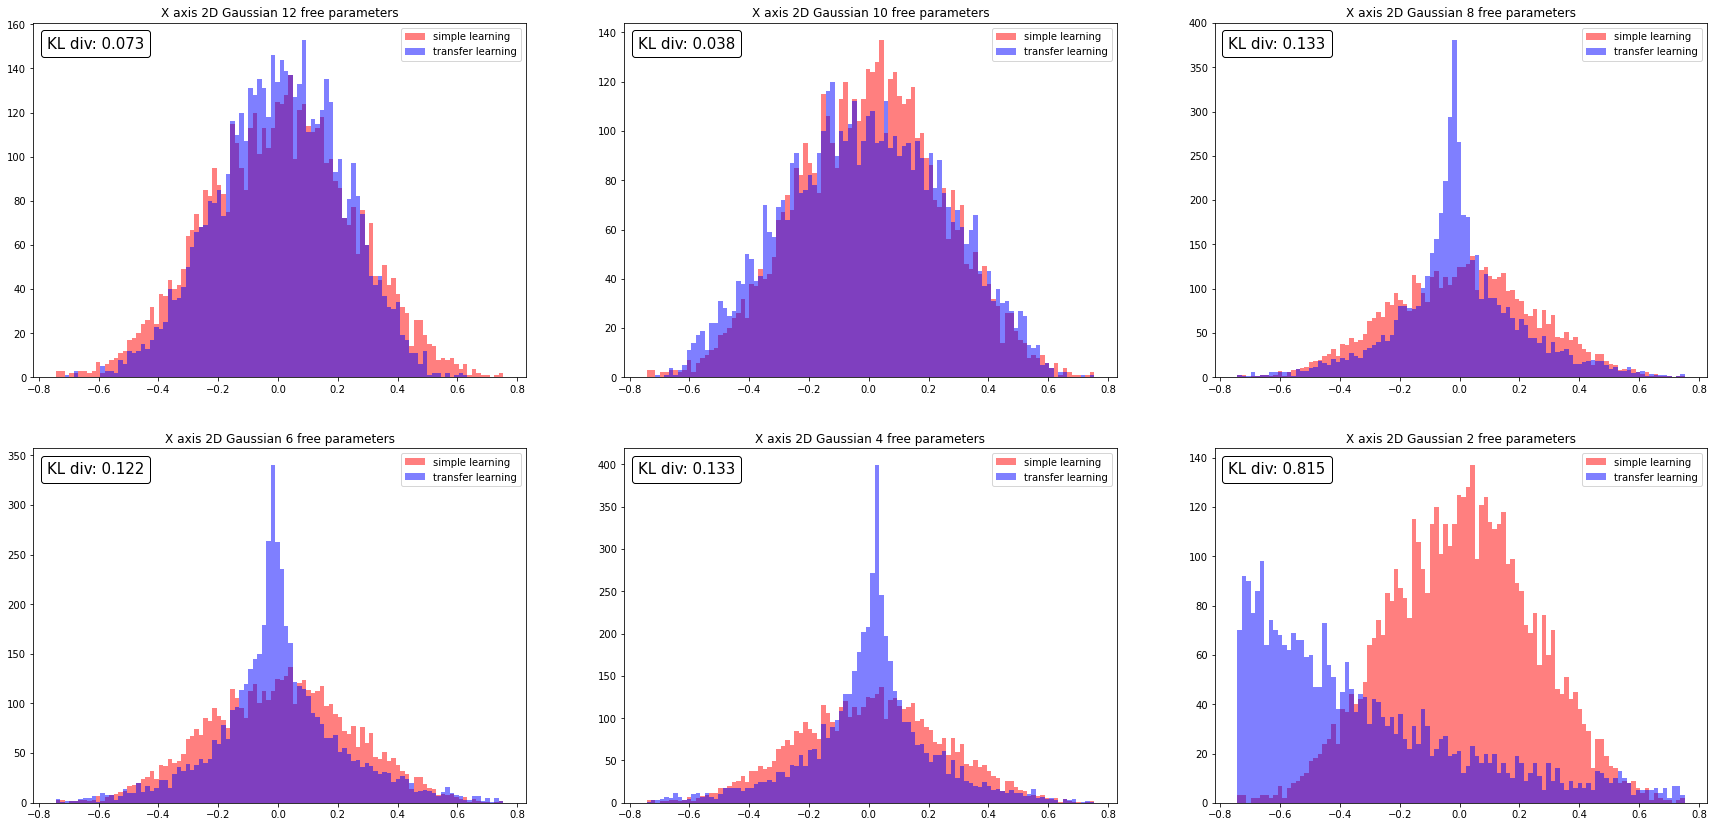

In [7]:
fig = plt.figure(figsize=(30,30))
for i, val in enumerate(fixed_params):
    
    pyplot.subplot(rows,cols,i+1)
    

    bins_real=pyplot.hist(x, color='red', bins=nbins,label='simple learning', alpha=0.5)
    bins_fake=pyplot.hist(distributionsX[i+1].numpy(), bins=bins_real[1],color='blue', label='transfer learning', alpha=0.5)

    pyplot.legend()
    pyplot.title(f"X axis 2D Gaussian {12-val} free parameters")
    
    ax=pyplot.gca()
    at = AnchoredText(
        f"KL div: {'%.3f' %kl_divergence(bins_real[0],bins_fake[0],epsilon=0.1)}", prop=dict(size=15), frameon=True, loc='upper left')
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    ax.add_artist(at)

pyplot.show()

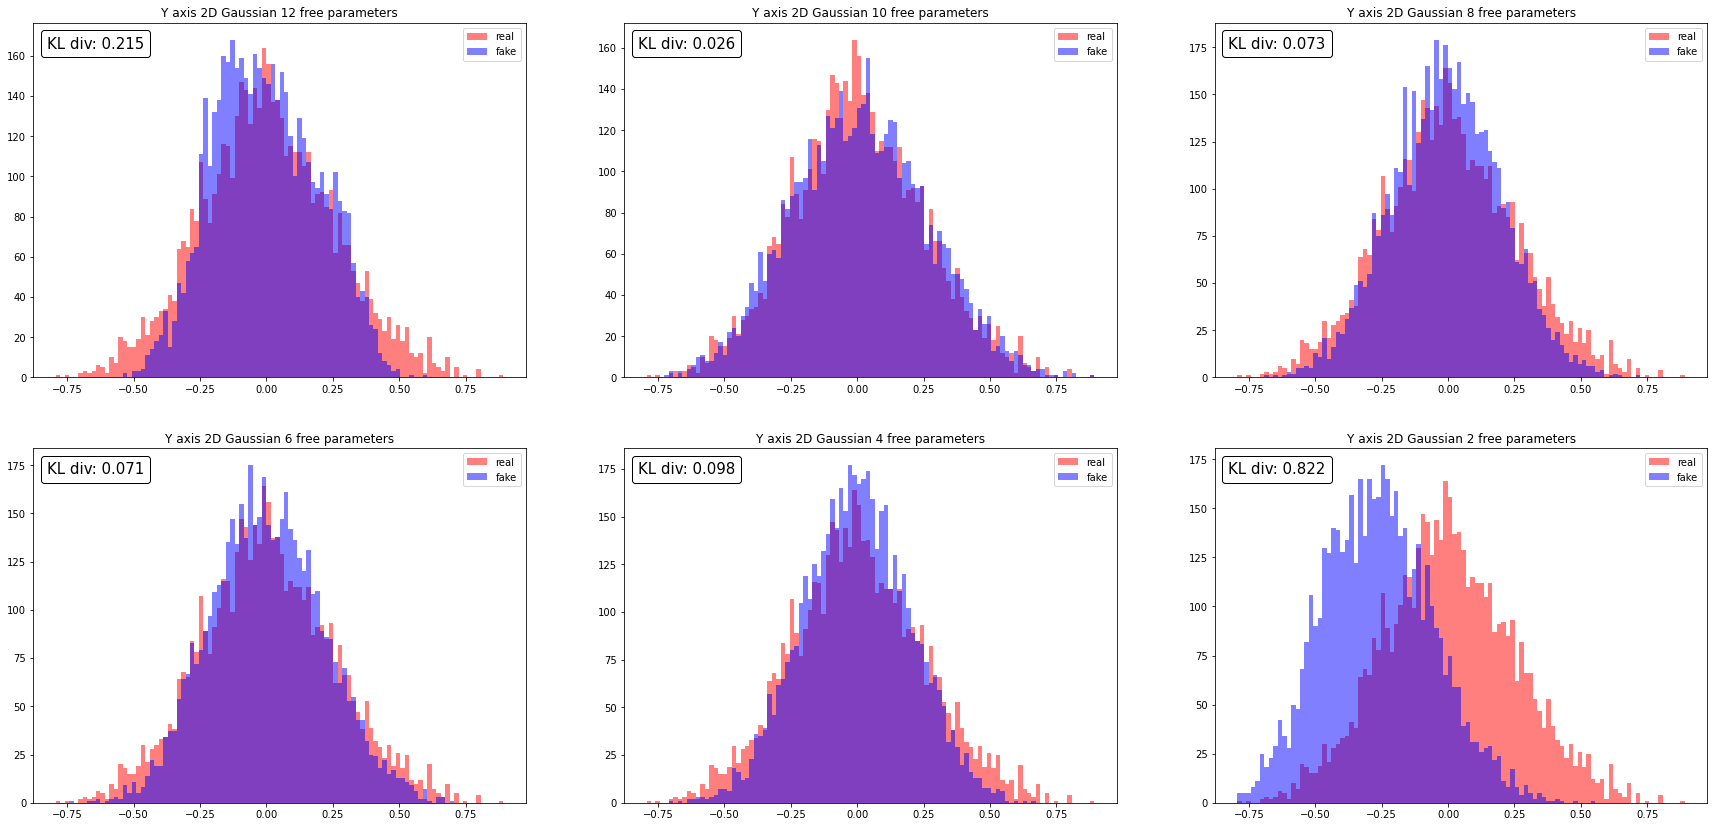

In [8]:
fig = plt.figure(figsize=(30,30))

for i, val in enumerate(fixed_params):
    
    pyplot.subplot(rows,cols,i+1)
    
    bins_real=pyplot.hist(real_distr[1].numpy(), color='red', bins=nbins,label='real', alpha=0.5)
    bins_fake=pyplot.hist(distributionsY[i+1].numpy(), bins=bins_real[1],color='blue', label='fake', alpha=0.5)

    pyplot.legend()
    pyplot.title(f"Y axis 2D Gaussian {12-val} free parameters")
    
    ax=pyplot.gca()
    at = AnchoredText(
        f"KL div: {'%.3f' %kl_divergence(bins_real[0],bins_fake[0],epsilon=0.1)}", prop=dict(size=15), frameon=True, loc='upper left')
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    ax.add_artist(at)


pyplot.show()

In [9]:
from IPython.display import display
from scipy import stats

moments = pd.DataFrame(
    {
        "distribution":["real x",*[f"fake x - {12 - 2*i} free parameters" for i in range(0,6)],"fake x simple learning" ],
        "mean":[*[np.mean(i) for i in distributionsX],np.mean(x)],
        "2 moment ":[*[stats.moment(i,moment=2) for i in distributionsX],stats.moment(x,moment=2)],
        "3 moment":[*[stats.moment(i,moment=3) for i in distributionsX],stats.moment(x,moment=3)],
        "4 moment ":[*[stats.moment(i,moment=4) for i in distributionsX],stats.moment(x,moment=4)]
    }
)
display(moments)

,distribution,mean,2 moment,3 moment,4 moment
0,real x,0.011103,0.062455,-0.001754,0.012546
1,fake x - 12 free parameters,0.007467,0.042494,-0.001197,0.004896
2,fake x - 10 free parameters,-0.008107,0.068834,-0.000138,0.011342
3,fake x - 8 free parameters,-0.003714,0.045367,0.001238,0.009561
4,fake x - 6 free parameters,0.002712,0.049313,0.001172,0.011425
5,fake x - 4 free parameters,0.002507,0.046705,-0.002286,0.010761
6,fake x - 2 free parameters,-0.533418,0.176620,0.095009,0.133878
7,fake x simple learning,0.005761,0.058674,-0.000241,0.009433


In [10]:
moments = pd.DataFrame(
    {
        "distribution":["real y",*[f"fake y - {12 - 2*i} free parameters" for i in range(0,6)],"fake y simple learning" ],
        "mean":[*[np.mean(i) for i in distributionsY],np.mean(y)],
        "2 moment ":[*[stats.moment(i,moment=2) for i in distributionsY],stats.moment(y,moment=2)],
        "3 moment":[*[stats.moment(i,moment=3) for i in distributionsY],stats.moment(y,moment=3)],
        "4 moment ":[*[stats.moment(i,moment=4) for i in distributionsY],stats.moment(y,moment=4)]
    }
)
display(moments)

,distribution,mean,2 moment,3 moment,4 moment
0,real y,0.003416,0.061682,0.001825,0.011147
1,fake y - 12 free parameters,-0.001524,0.037832,0.000875,0.003382
2,fake y - 10 free parameters,0.009208,0.063705,0.001311,0.011148
3,fake y - 8 free parameters,-0.006602,0.041801,0.000106,0.005013
4,fake y - 6 free parameters,0.003259,0.044835,0.001045,0.005716
5,fake y - 4 free parameters,-0.002734,0.040239,-0.000130,0.004620
6,fake y - 2 free parameters,-0.262796,0.042963,0.001870,0.005314
7,fake y simple learning,-0.022340,0.058887,0.000163,0.009443
